In [1]:
#!pip install tensorflow -i https://pypi.tuna.tsinghua.edu.cn/simple/

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
import itertools
# 注册 matplotlib 转换器
register_matplotlib_converters()
import warnings
warnings.filterwarnings('ignore')

In [5]:
data = pd.read_csv("D:/data.csv")

In [6]:
csv_file_path = 'data.csv'
data.to_csv(csv_file_path, index=False, encoding='utf-8-sig')

In [7]:
# 查看数据维度
data.shape

(1036, 7)

In [8]:
# 查看数据信息
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1036 entries, 0 to 1035
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   日期      1036 non-null   object 
 1   收盘      1036 non-null   float64
 2   开盘      1036 non-null   float64
 3   高       1036 non-null   float64
 4   低       1036 non-null   float64
 5   交易量     1036 non-null   object 
 6   涨跌幅     1036 non-null   float64
dtypes: float64(5), object(2)
memory usage: 56.8+ KB


In [9]:
# 查看重复值
data.duplicated().sum()

0

In [10]:
# 将日期列转换为日期格式
data['日期'] = pd.to_datetime(data['日期'])

# 自定义一个函数来处理交易量的字符串
def parse_volume(volume):
    if isinstance(volume, str):
        if 'M' in volume:
            return float(volume.replace('M', '')) * 1_000_000
        elif 'K' in volume:
            return float(volume.replace('K', '')) * 1_000
    return float(volume)


# 使用自定义函数解析交易量
data['交易量'] = data['交易量'].apply(parse_volume)
# 按日期进行排序
data = data.sort_values(by='日期')

In [11]:
data.head()

,日期,收盘,开盘,高,低,交易量,涨跌幅
1035,2021-02-08,7.91,7.91,7.91,7.91,324910.0,0.1001
1034,2021-02-09,8.70,8.70,8.70,8.70,473570.0,0.0999
1033,2021-02-10,9.57,9.57,9.57,9.57,716930.0,0.1000
1032,2021-02-18,10.53,10.53,10.53,10.53,522690.0,0.1003
1031,2021-02-19,11.58,11.58,11.58,11.58,1570000.0,0.0997


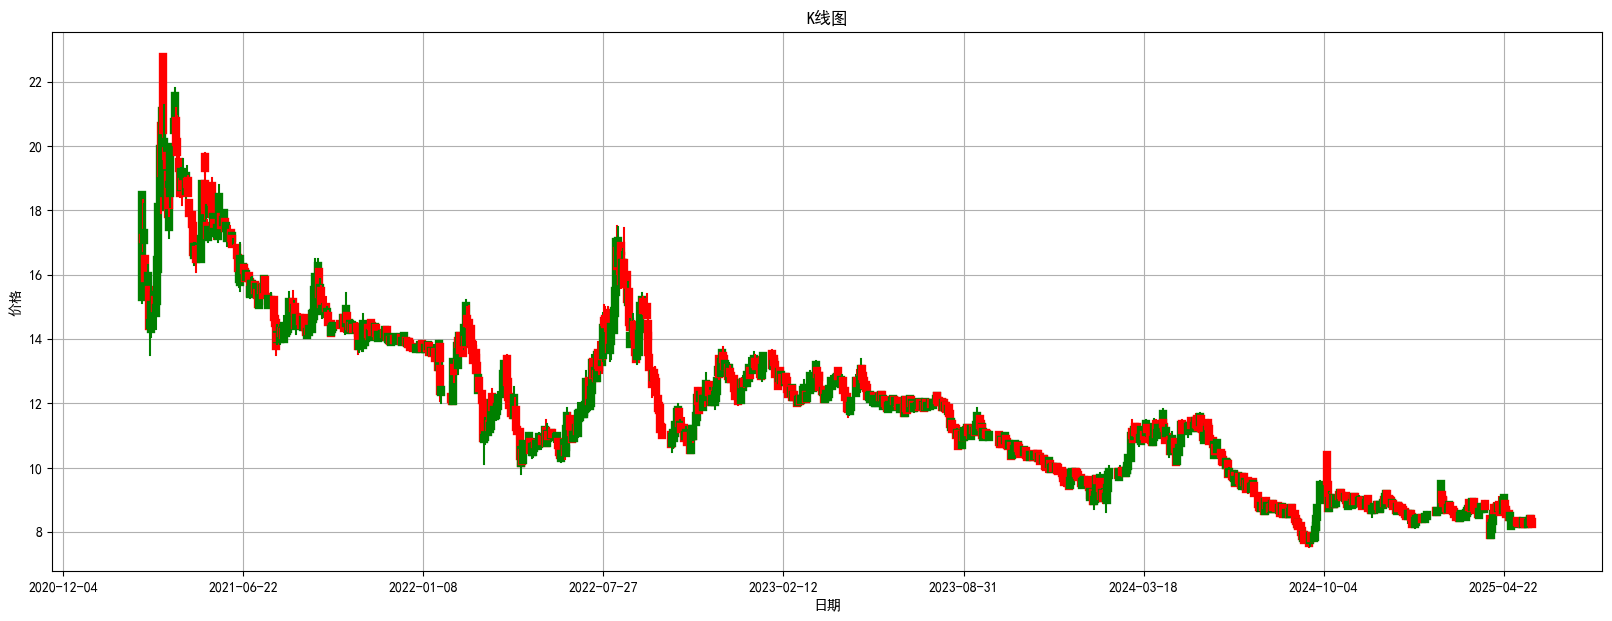

In [13]:
plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认中文字体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示异常

# 绘制K线图
fig, ax = plt.subplots(figsize=(20,7))

# 绘制蜡烛图
for i, row in data.iterrows():
    color = 'green' if row['收盘'] >= row['开盘'] else 'red'
    ax.plot([row['日期'], row['日期']], [row['低'], row['高']], color=color)
    ax.plot([row['日期'], row['日期']], [row['开盘'], row['收盘']], linewidth=6, color=color)

# 设置图表的X轴和Y轴
ax.xaxis_date()
ax.xaxis.set_major_locator(MaxNLocator(10))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=0)
plt.xlabel('日期')
plt.ylabel('价格')
plt.title('K线图')
plt.grid(True)

plt.show()

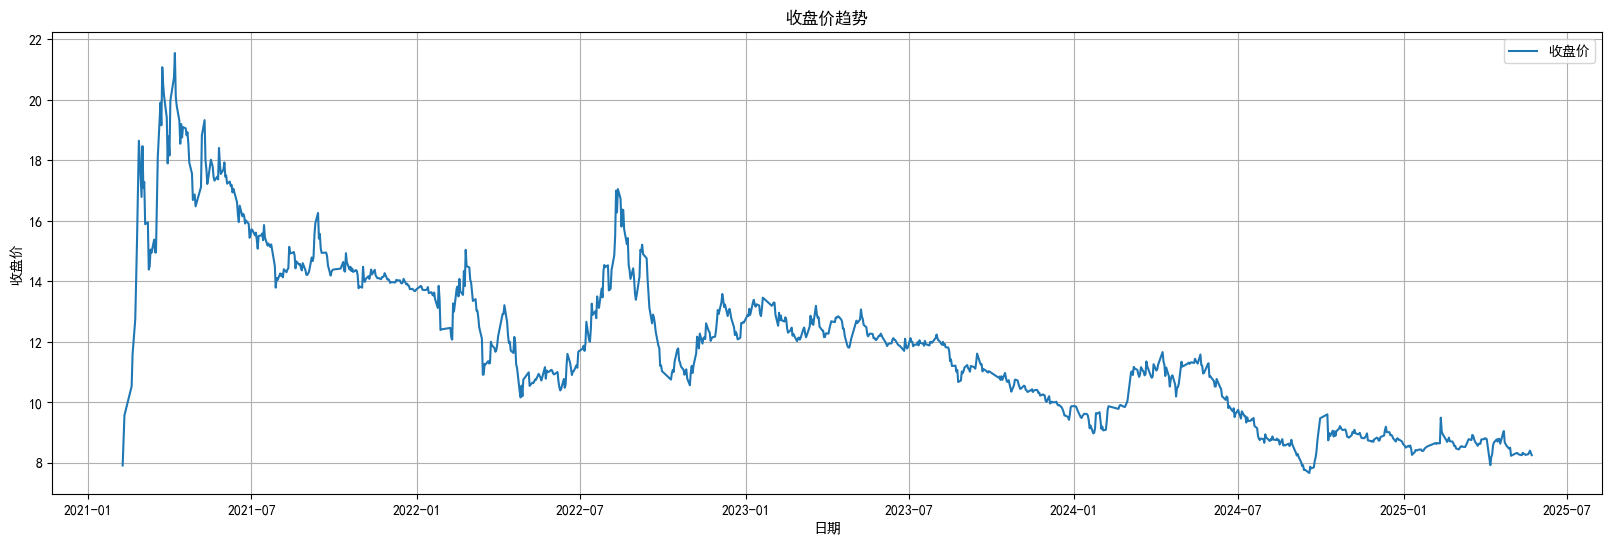

In [14]:
plt.figure(figsize=(20, 6))
plt.plot(data['日期'], data['收盘'], label='收盘价')
plt.xlabel('日期')
plt.ylabel('收盘价')
plt.title('收盘价趋势')
plt.xticks(rotation=0)
plt.legend()
plt.grid(True)
plt.show()

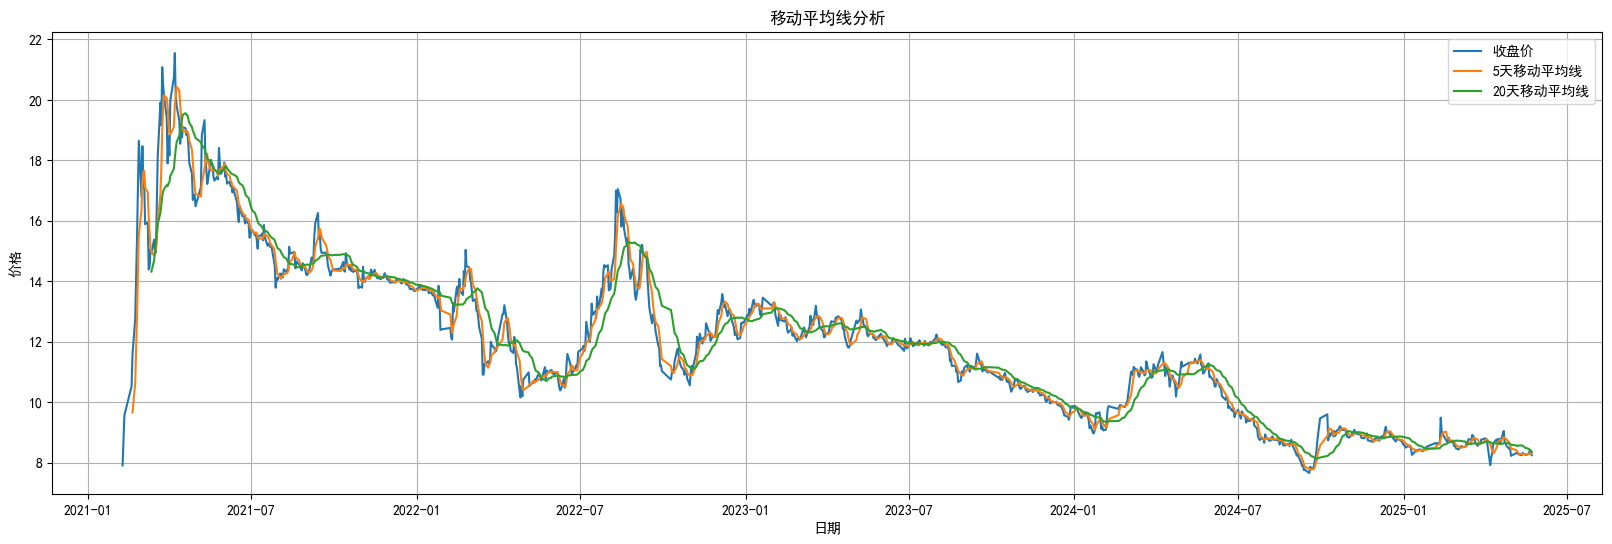

In [15]:
# 移动平均线
data['移动平均线_5天'] = data['收盘'].rolling(window=5).mean()
data['移动平均线_20天'] = data['收盘'].rolling(window=20).mean()

plt.figure(figsize=(20, 6))
plt.plot(data['日期'], data['收盘'], label='收盘价')
plt.plot(data['日期'], data['移动平均线_5天'], label='5天移动平均线')
plt.plot(data['日期'], data['移动平均线_20天'], label='20天移动平均线')
plt.xlabel('日期')
plt.ylabel('价格')
plt.title('移动平均线分析')
plt.xticks(rotation=0)
plt.legend()
plt.grid(True)
plt.show()

In [16]:
def calculate_rsi(series, period=14):
    delta = series.diff().dropna()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

data['RSI'] = calculate_rsi(data['收盘'])

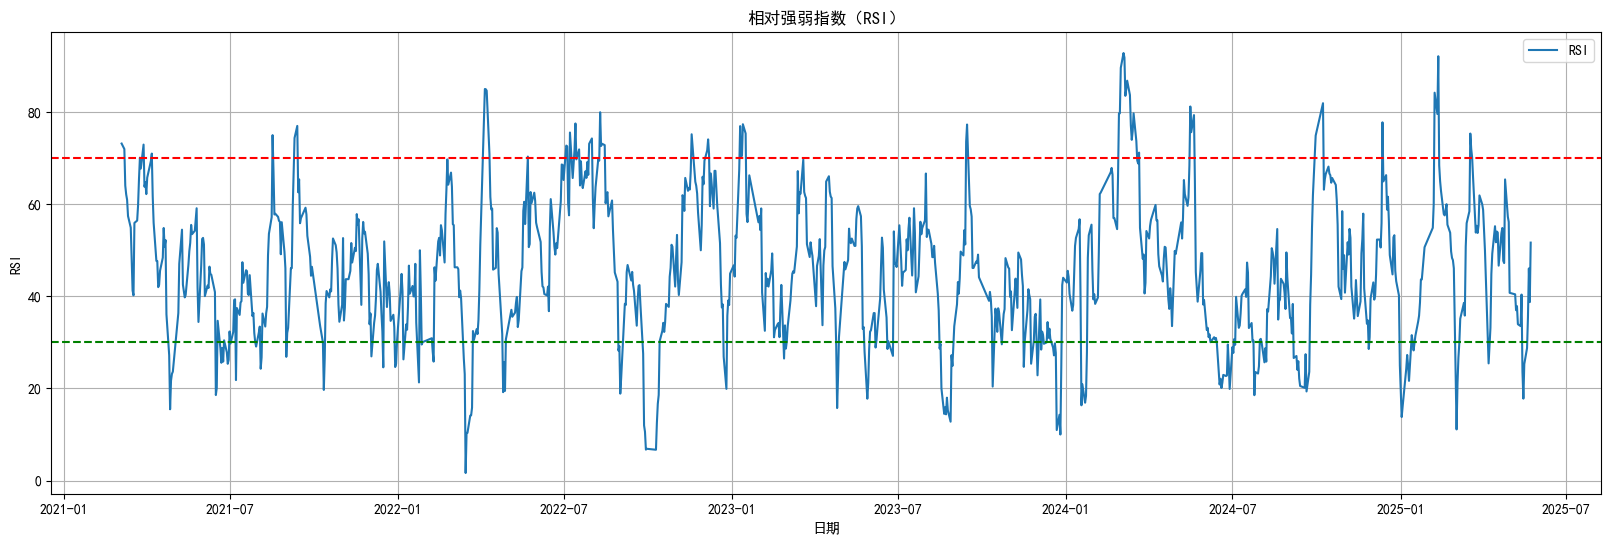

In [17]:
plt.figure(figsize=(20, 6))
plt.plot(data['日期'], data['RSI'], label='RSI')
plt.xlabel('日期')
plt.ylabel('RSI')
plt.title('相对强弱指数（RSI）')
plt.xticks(rotation=45)
plt.axhline(y=70, color='r', linestyle='--')
plt.axhline(y=30, color='g', linestyle='--')
plt.legend()
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

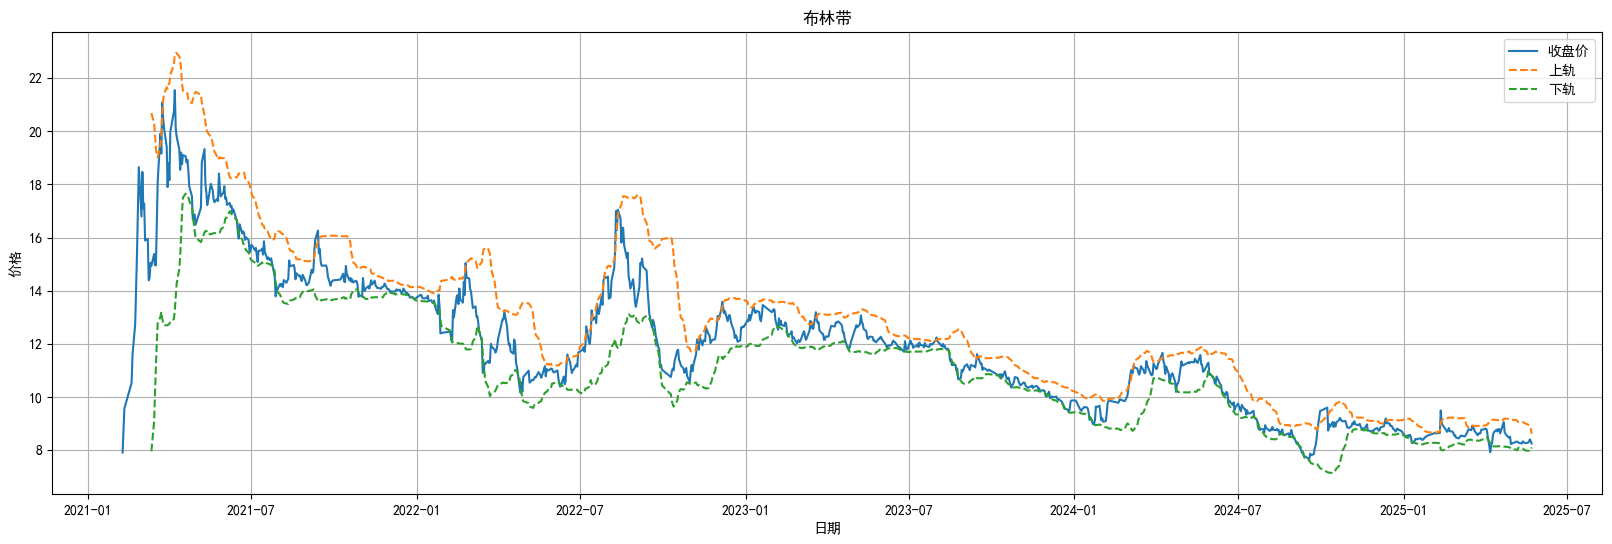

In [18]:
data['标准差'] = data['收盘'].rolling(window=20).std()
data['上轨'] = data['移动平均线_20天'] + (data['标准差'] * 2)
data['下轨'] = data['移动平均线_20天'] - (data['标准差'] * 2)

plt.figure(figsize=(20, 6))
plt.plot(data['日期'], data['收盘'], label='收盘价')
plt.plot(data['日期'], data['上轨'], label='上轨', linestyle='--')
plt.plot(data['日期'], data['下轨'], label='下轨', linestyle='--')
plt.xlabel('日期')
plt.ylabel('价格')
plt.title('布林带')
plt.xticks(rotation=0)
plt.legend()
plt.grid(True)
plt.show()

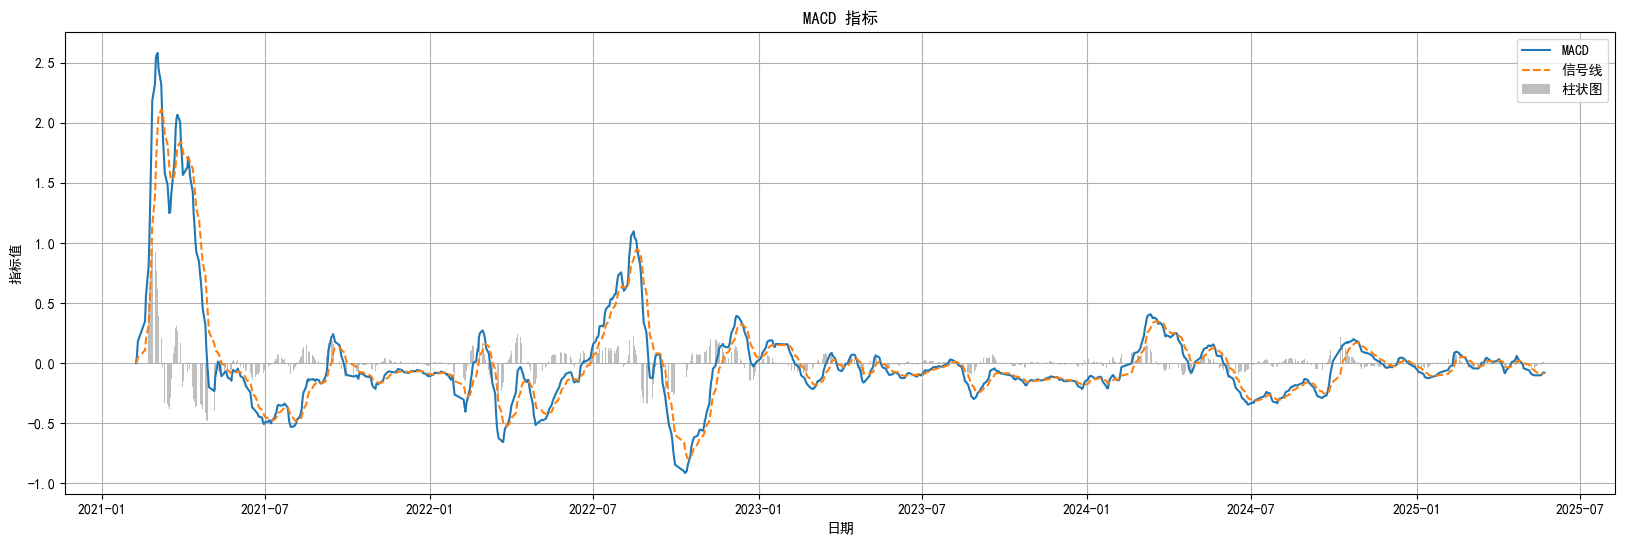

In [19]:
# 计算 MACD
def calculate_macd(data, fast_period=12, slow_period=26, signal_period=9):
    fast_ema = data['收盘'].ewm(span=fast_period, adjust=False).mean()
    slow_ema = data['收盘'].ewm(span=slow_period, adjust=False).mean()
    data['MACD'] = fast_ema - slow_ema
    data['信号线'] = data['MACD'].ewm(span=signal_period, adjust=False).mean()
    data['柱状图'] = data['MACD'] - data['信号线']
    return data

# 计算 MACD
data = calculate_macd(data)

# 绘制 MACD 图
plt.figure(figsize=(20, 6))
plt.plot(data['日期'], data['MACD'], label='MACD')
plt.plot(data['日期'], data['信号线'], label='信号线', linestyle='--')
plt.bar(data['日期'], data['柱状图'], label='柱状图', color='grey', alpha=0.5)
plt.xlabel('日期')
plt.ylabel('指标值')
plt.title('MACD 指标')
plt.legend()
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

In [20]:
# 使用MinMaxScaler进行数据归一化
scaler = MinMaxScaler(feature_range=(0,1))
data_scaled = scaler.fit_transform(data[['收盘']])

In [21]:
# 准备训练和测试数据集
def create_dataset(data, look_back=1):
    x,y = [], []
    for i in range(len(data) - look_back):
        x.append(data[i:(i + look_back), 0])
        y.append(data[i + look_back, 0])
    return np.array(x), np.array(y)

# 设置look_back参数
look_back = 5 # 表示每个输入样本包含 5 个时间步的数据作为特征，目标是序列的下一个时间步的数据。

# 生成训练数据
x,y = create_dataset(data_scaled, look_back=look_back)

# 将数据形状调整为 LSTM 输入格式
x = np.reshape(x, (x.shape[0], x.shape[1], 1))

In [22]:
# 构建LSTM模型
model = Sequential([
    LSTM(50, return_sequences=False, input_shape=(look_back, 1)),
    Dense(1)
])

# 编译模型
model.compile(optimizer='adam', loss='mean_squared_error')

# 训练模型
model.fit(x,y, epochs=20, batch_size=32, verbose=1)

Epoch 1/20
33/33 [==============================] - 1s 2ms/step - loss: 0.0583
Epoch 2/20
33/33 [==============================] - 0s 2ms/step - loss: 0.0090
Epoch 3/20
33/33 [==============================] - 0s 2ms/step - loss: 0.0036
Epoch 4/20
33/33 [==============================] - 0s 2ms/step - loss: 0.0023
Epoch 5/20
33/33 [==============================] - 0s 2ms/step - loss: 0.0023
Epoch 6/20
33/33 [==============================] - 0s 1ms/step - loss: 0.0022
Epoch 7/20
33/33 [==============================] - 0s 1ms/step - loss: 0.0022
Epoch 8/20
33/33 [==============================] - 0s 2ms/step - loss: 0.0021
Epoch 9/20
33/33 [==============================] - 0s 2ms/step - loss: 0.0020
Epoch 10/20
33/33 [==============================] - 0s 1ms/step - loss: 0.0020
Epoch 11/20
33/33 [==============================] - 0s 2ms/step - loss: 0.0019
Epoch 12/20
33/33 [==============================] - 0s 1ms/step - loss: 0.0019
Epoch 13/20
33/33 [==============================

In [23]:
# 生成预测
predictions = model.predict(x)

# 反归一化预测值和真实值
predictions = scaler.inverse_transform(predictions)
actual = scaler.inverse_transform(y.reshape(-1, 1))

# 评估指标
mse = mean_squared_error(actual, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual, predictions)

print(f"均方误差（MSE）: {mse}")
print(f"均方根误差（RMSE）: {rmse}")
print(f"平均绝对误差（MAE）: {mae}")

33/33 [==============================] - 0s 906us/step
均方误差（MSE）: 0.32291745501580915
均方根误差（RMSE）: 0.5682582643620849
平均绝对误差（MAE）: 0.36624543187227443


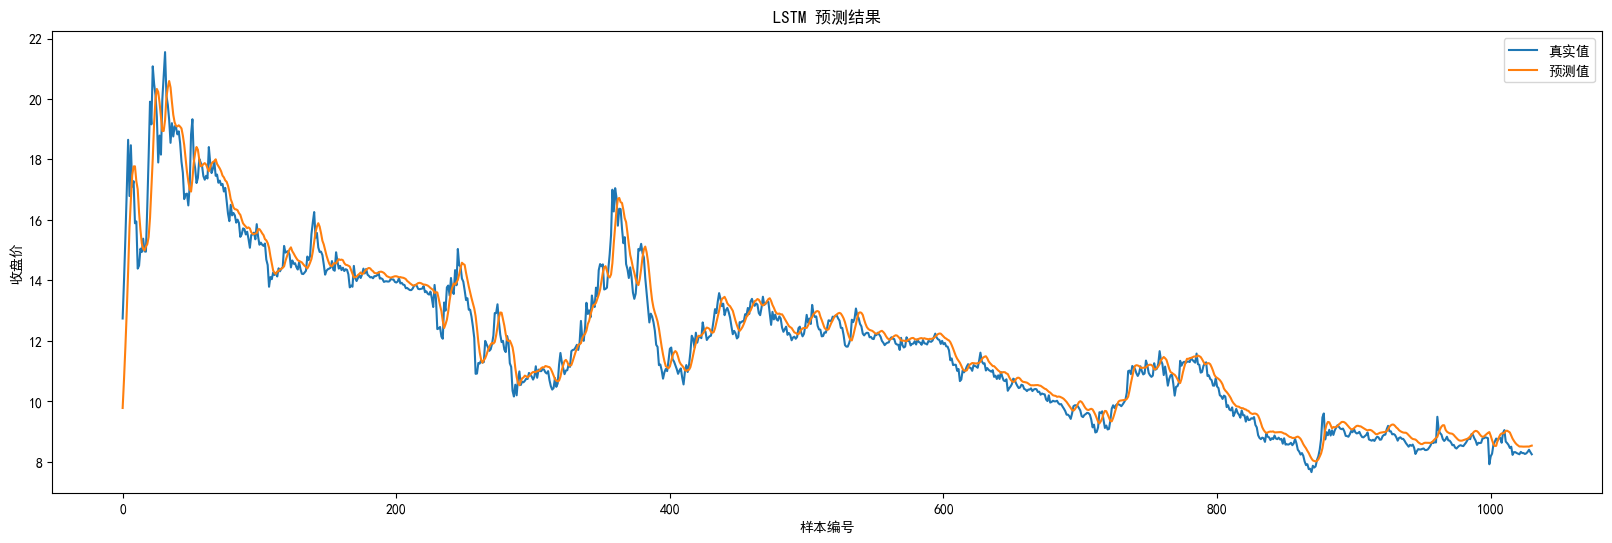

In [24]:
# 可视化结果
plt.figure(figsize=(20,6))
plt.plot(actual, label='真实值')
plt.plot(predictions, label='预测值')
plt.legend()
plt.xlabel('样本编号')
plt.ylabel('收盘价')
plt.title('LSTM 预测结果')
plt.show()

In [25]:
# 创建 LSTM 模型的函数
def create_model(units=50, dropout=0.2, optimizer='adam'):
    model = Sequential([
        LSTM(units, return_sequences=False, input_shape=(look_back, 1)),
        Dropout(dropout),
        Dense(1)
    ])
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# 超参数搜索函数
def hyperparameter_search(x, y, param_distribs):
    best_score = float('inf')
    best_params = None
    
    # 遍历所有参数组合
    for units, dropout, optimizer, batch_size, epochs in itertools.product(
            param_distribs['units'], 
            param_distribs['dropout'], 
            param_distribs['optimizer'], 
            param_distribs['batch_size'], 
            param_distribs['epochs']):
        
        # 创建并训练模型
        model = create_model(units=units, dropout=dropout, optimizer=optimizer)
        model.fit(x, y, batch_size=batch_size, epochs=epochs, verbose=0)
        
        # 计算评分
        y_pred = model.predict(x)
        score = mean_squared_error(y, y_pred)
        
        # 保存最佳参数
        if score < best_score:
            best_score = score
            best_params = {
                'units': units,
                'dropout': dropout,
                'optimizer': optimizer,
                'batch_size': batch_size,
                'epochs': epochs
            }

    return best_params, best_score

# 定义超参数搜索范围
param_distribs = {
    'units': [10, 20, 50, 100],
    'dropout': [0.2, 0.3, 0.4],
    'optimizer': ['adam', 'rmsprop'],
    'batch_size': [16, 32, 64],
    'epochs': [20, 30, 50]
}

# 执行超参数搜索
best_params, best_score = hyperparameter_search(x, y, param_distribs)
print("最佳参数:", best_params)
print("最佳模型得分:", best_score)

33/33 [==============================] - 0s 847us/step


33/33 [==============================] - 0s 1ms/step
最佳参数: {'units': 100, 'dropout': 0.2, 'optimizer': 'rmsprop', 'batch_size': 16, 'epochs': 50}
最佳模型得分: 0.0006370792254183916


In [26]:
# 用最佳参数构建模型
def create_optimized_model(units=50, dropout=0.2, optimizer='adam'):
    model = Sequential([
        LSTM(units, return_sequences=False, input_shape=(look_back, 1)),
        Dropout(dropout),
        Dense(1)
    ])
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# 使用最佳参数来创建模型
optimized_model = create_optimized_model(
    units=best_params['units'],
    dropout=best_params['dropout'],
    optimizer=best_params['optimizer']
)

# 训练新的模型
optimized_model.fit(x, y, epochs=best_params['epochs'], batch_size=best_params['batch_size'])

Epoch 1/50
65/65 [==============================] - 1s 2ms/step - loss: 0.0139
Epoch 2/50
65/65 [==============================] - 0s 2ms/step - loss: 0.0027
Epoch 3/50
65/65 [==============================] - 0s 2ms/step - loss: 0.0027
Epoch 4/50
65/65 [==============================] - 0s 2ms/step - loss: 0.0023
Epoch 5/50
65/65 [==============================] - 0s 2ms/step - loss: 0.0022
Epoch 6/50
65/65 [==============================] - 0s 2ms/step - loss: 0.0021
Epoch 7/50
65/65 [==============================] - 0s 2ms/step - loss: 0.0022
Epoch 8/50
65/65 [==============================] - 0s 2ms/step - loss: 0.0022
Epoch 9/50
65/65 [==============================] - 0s 2ms/step - loss: 0.0018
Epoch 10/50
65/65 [==============================] - 0s 2ms/step - loss: 0.0018
Epoch 11/50
65/65 [==============================] - 0s 2ms/step - loss: 0.0017
Epoch 12/50
65/65 [==============================] - 0s 2ms/step - loss: 0.0019
Epoch 13/50
65/65 [==============================

In [27]:
# 生成预测
predictions_optimized = optimized_model.predict(x)

# 反归一化预测值和真实值
predictions_optimized = scaler.inverse_transform(predictions_optimized)

# 评估指标
mse = mean_squared_error(actual, predictions_optimized)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual, predictions_optimized)

print(f"均方误差（MSE）: {mse}")
print(f"均方根误差（RMSE）: {rmse}")
print(f"平均绝对误差（MAE）: {mae}")

33/33 [==============================] - 0s 1ms/step
均方误差（MSE）: 0.13109482006416098
均方根误差（RMSE）: 0.36207018665468854
平均绝对误差（MAE）: 0.21434432056549102


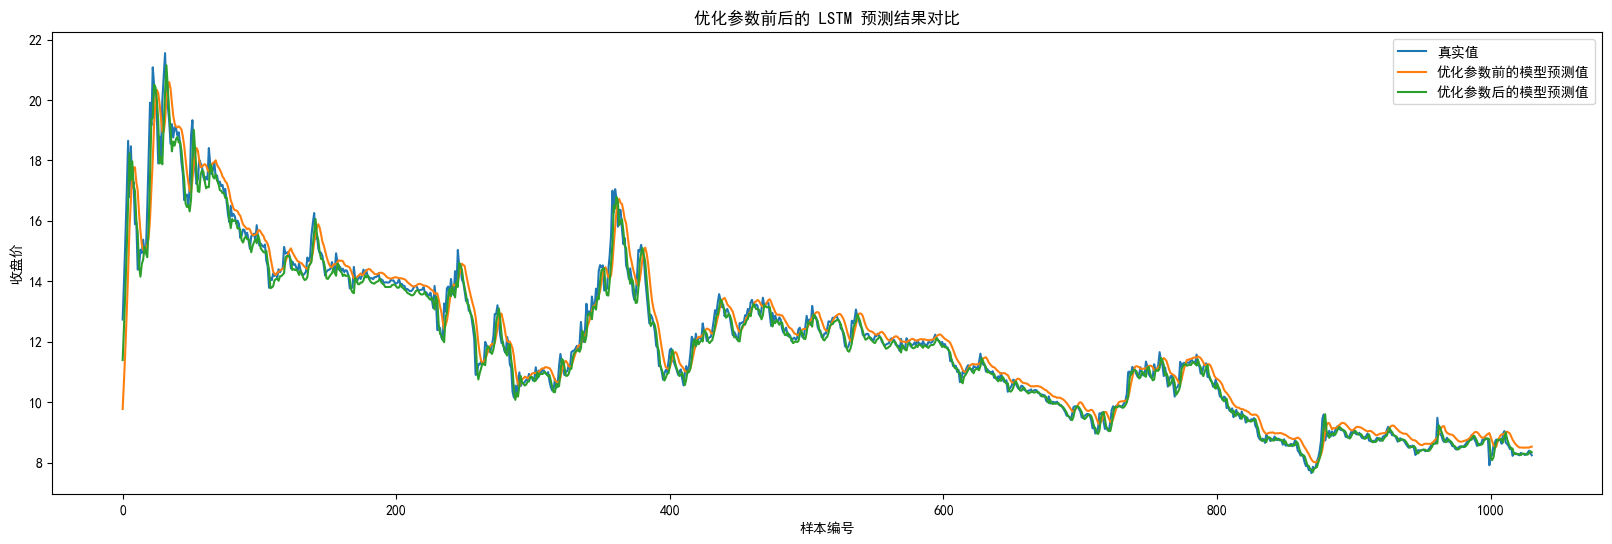

In [28]:
# 可视化结果
plt.figure(figsize=(20,6))
plt.plot(actual, label='真实值')
plt.plot(predictions, label='优化参数前的模型预测值')
plt.plot(predictions_optimized, label='优化参数后的模型预测值')
plt.legend()
plt.xlabel('样本编号')
plt.ylabel('收盘价')
plt.title('优化参数前后的 LSTM 预测结果对比')
plt.show()